# Anchors VS Minimal Sufficient Rules

In [1]:
import argparse
import numpy as np
from data_generation import generate_dataset
from invase_regression import invase
from utils import feature_performance_metric, prediction_performance_metric   
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
# from skranger.ensemble.classifier import RangerForestClassifier
from sklearn.ensemble import RandomForestRegressor
from acv_explainers.acv_tree import ACVTreeAgnostic
# Necessary packages
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Comparisons of rules on moon data with switch

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument(
  '--data_type',
  choices=['syn1','syn2','syn3','syn4','syn5','syn6', 'syn7', 'syn8', 'syn_moons'],
  default='syn_moons',
  type=str)
parser.add_argument(
  '--train_no',
  help='the number of training data',
  default=10000,
  type=int)
parser.add_argument(
  '--test_no',
  help='the number of testing data',
  default=10000,
  type=int)
parser.add_argument(
  '--dim',
  help='the number of features',
  choices=[11, 100],
  default=100,
  type=int)

args = parser.parse_args([]) 

# Generate dataset
d = args.dim
p = 0.8
mean = np.zeros(d)
coefs = np.ones(d)
# Determinitist covariance
cov = p*np.ones(shape=(d, d)) + 5*np.eye(d)
# b = np.random.randn(d, d)
# cov = np.dot(b, b.T)

x_train, y_train, g_train = generate_dataset (mean, cov, n = args.train_no, 
                                            dim = args.dim, 
                                            data_type = args.data_type, 
                                            seed = 0, reg=True, coefs=coefs)

x_test, y_test, g_test = generate_dataset (mean, cov, n = args.test_no,
                                         dim = args.dim, 
                                         data_type = args.data_type, 
                                         seed = 5, reg=True, coefs=coefs)

# RF training

In [3]:
# minimal number of obersations in each leaf
n = x_train.shape[0]
tn = np.ceil((np.sqrt(n)*np.log(n)**(1.5))/250)
tn

12.0

In [4]:
model = RandomForestClassifier(n_estimators=10, min_samples_leaf=int(tn), max_depth=8, max_features=x_train.shape[1])
for i in range(2):
    model.fit(x_train, y_train)
print('AUC = {}'.format(roc_auc_score(model.predict(x_test), y_test)))

AUC = 0.9958929227752196


### Initialization of the Explainer

In [5]:
acvtree = ACVTreeAgnostic(model, x_train)

100%|██████████| 10/10 [00:00<00:00, 47.11it/s]


# Launch the webAPP ?

- Execute the following code if you wan to run the webapp to easily navigate between the different explanations

In [6]:
max_size = 10000
x_train = pd.DataFrame(x_train[:max_size], columns=['X{}'.format(i) for i in range(x_train.shape[1])])
x_test = pd.DataFrame(x_test[:max_size], columns=['X{}'.format(i) for i in range(x_test.shape[1])])
y_test = pd.DataFrame(y_test[:max_size])
y_train = pd.DataFrame(y_train[:max_size])

- Save the model and data

In [31]:
import acv_app
import os

acv_app.compile_acv(model, x_train, y_train, x_test, y_test, path=os.getcwd())

100%|██████████| 10/10 [00:00<00:00, 49.89it/s]


- Launch the webapp

In [33]:
# # Give the path where the model and data are saved
# acv_app.run_webapp(pickle_path=os.getcwd())

# Plot the Data

In [9]:
data_plots = x_train.copy()
data_plots['label'] = y_train.values.reshape(-1)

In [10]:
c = ['#3e82fc', '#ff073a']

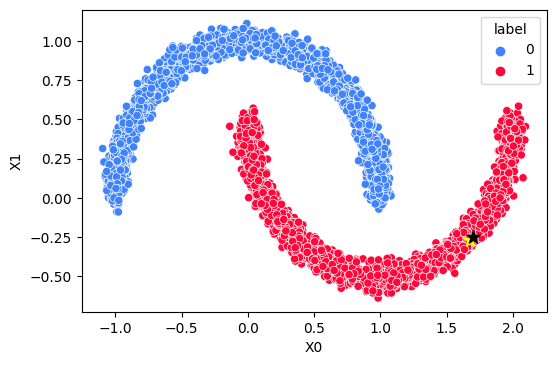

In [11]:
plt.figure(dpi=100)
sns.scatterplot(x='X0', y='X1', hue='label', data=data_plots[data_plots['X2']>=0], palette=c)

# idx = np.random.randint(0, x_test.shape[0])
idx = 9651
# print(idx)
nearest = (x_test.values[:, 0] <= x_test.values[idx, 0] + 0.05)*(x_test.values[:, 0] >= x_test.values[idx, 0] - 0.05) *\
(x_test.values[:, 1] <= x_test.values[idx, 1] + 0.05)*(x_test.values[:, 1] >= x_test.values[idx, 1] - 0.05)\
*(x_test.values[:, 2] * x_test.values[idx, 2]>=0)


idx_nb = np.argwhere(nearest==1).reshape(-1)[0]
plt.scatter(x_test.values[idx][0], x_test.values[idx][1], marker='*', c = 'yellow', s=100)

plt.scatter(x_test.values[idx_nb][0], x_test.values[idx_nb][1], marker='*', c = 'black', s=100)

- The instance chosen for the explanations

In [12]:
x_test.values[idx]

array([ 1.67439471, -0.26979243,  2.45912138, -2.38213197, -1.02264759,
        2.32858565, -0.55838754, -1.62363337,  2.59401391,  2.47573447,
        0.40087424,  0.55638761,  3.92260289,  0.88100923,  3.66441489,
        1.13558174,  4.56749715,  3.08458167,  1.63837033, -1.7899942 ,
       -0.17951391,  3.88434371,  1.43739797, -0.53758558, -0.39547486,
        3.11231051,  1.87857569, -0.39907085,  2.7570481 ,  0.39652763,
       -0.30545201,  1.41868631,  0.0985277 ,  1.52860572, -2.29084732,
        1.51891783, -0.16128722,  0.38003486,  2.91776537,  5.00921654,
        1.84838886, -0.68581882, -0.57387046, -0.67416   , -4.59736526,
       -2.2378544 ,  2.0083963 ,  3.97009969, -2.22843856, -1.20766821,
       -0.019611  ,  5.58207608, -3.47635418, -0.26006146, -1.54200934,
        1.381136  ,  4.53952882,  0.47002986,  5.33272813,  0.40572475,
       -0.26984257,  0.14343021,  2.40205952,  0.71324801, -1.97784432,
       -0.40503261,  2.34726324, -1.85910301, -0.97050865,  0.11

- The nearest point of the chosen instance 

In [13]:
x_test.values[idx_nb]

array([ 1.69841522, -0.25189561,  0.13912837,  4.56409876,  2.02997016,
        1.12333716,  3.23444793,  0.25672399, -0.78340494, -2.3553519 ,
        0.26732025,  1.3654945 ,  1.25571365, -0.86864822,  0.47616184,
       -0.68439477, -2.72242538,  2.03593036,  4.71086766, -1.37162303,
       -0.13295093,  1.44230404, -0.91535972, -0.03760533,  1.19684236,
        1.92018904,  1.74878714, -0.71768829, -1.2875184 , -0.97239263,
       -2.48902482,  3.51031769, -2.53263553, -1.88839015, -1.09435329,
       -3.14014908,  1.61365973,  3.30481995,  0.58373793, -3.18834218,
       -1.77766502,  0.59793742, -2.81813895, -0.32242512, -1.89276232,
       -0.38189222, -0.3255856 , -2.20486247,  0.79225396, -0.47236964,
       -1.49839783, -1.2463898 ,  1.07714181,  1.84073577,  0.16934732,
        0.91166956,  0.15447635,  1.54746349, -0.87373893, -2.26732584,
        0.62835234, -3.47482772,  1.62127957,  1.85170695,  1.25925812,
        0.27858618, -5.38491872, -1.91371604, -3.92923606,  2.34

# Anchors Fitting

In [14]:
from anchor import anchor_tabular

In [15]:
columns = ['X{}'.format(i) for i in range(x_train.shape[1])]

In [16]:
explainer = anchor_tabular.AnchorTabularExplainer(
    ['0', '1'],
    columns,
    x_train.values[:5000])

#### Rules of the reference point

In [17]:
# idx = 607
import time
t0 = time.perf_counter()
exp = explainer.explain_instance(x_test.values[idx], model.predict, threshold=0.95, delta=0.05, max_anchor_size=5)
t1 = time.perf_counter()
print(t1 - t0)
exp.names()

50.48198065600013


['X0 > 1.03', 'X2 > 0.02', 'X1 <= -0.21']

In [18]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: X0 > 1.03 AND X2 > 0.02 AND X1 <= -0.21
Precision: 1.00
Coverage: 0.06


#### Rules of the nearest point

In [19]:
import time
t0 = time.perf_counter()
exp = explainer.explain_instance(x_test.values[idx_nb], model.predict, threshold=0.95, delta=0.05, max_anchor_size=30)
t1 = time.perf_counter()
print(t1 - t0)
exp.names()

56.578024928000104


['X8 > -1.61', 'X92 > 1.68', 'X0 > -0.03', 'X2 > 0.02', 'X1 <= -0.21']

In [20]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: X8 > -1.61 AND X92 > 1.68 AND X0 > -0.03 AND X2 > 0.02 AND X1 <= -0.21
Precision: 1.00
Coverage: 0.03


**Important**: Re-run the previous cell to see the instability of Anchors

- Plot of the rules of the reference point with anchors

In [21]:
X = x_train.values.copy()
plot_step = 0.01

(-1.5, 2.0)

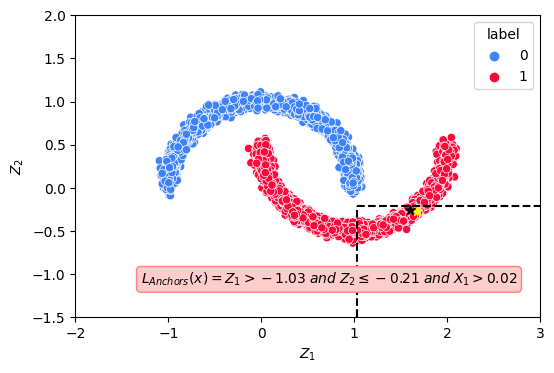

In [22]:
plt.figure(dpi=100)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
plot_X = np.c_[xx.ravel(), yy.ravel()]

def rule(X):
    Y = []
    A = []
    j = 0
    for i in range(X.shape[0]):
        if X[i, 1] <=  -0.21 and 1.03  <= X[i, 0]:
            j += 1
            Y.append(0)
        elif X[i, 1] >=  -0.0323284026235342 and 1.4608486890792847  <= X[i, 0]:
            Y.append(1)
        elif X[i, 1] <=  -0.0323284026235342 and 1.4608486890792847  >= X[i, 0]:
            Y.append(1)
        else:
            Y.append(4)
    return np.array(Y), np.array(A)

Z, A = rule(plot_X)
Z = Z.reshape(xx.shape)
# A = A.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, colors='white', linestyles='dashed')
# cs = plt.contourf(xx, yy, A)
# plt.colorbar()
sns.scatterplot(x='X0', y='X1', hue='label', data=data_plots[data_plots["X2"]>=0], palette=c)
plt.scatter(x_test.values[idx][0], x_test.values[idx][1], marker='*', c ='yellow', s=50)
plt.scatter(x_test.values[idx_nb][0]-0.1, x_test.values[idx_nb][1], marker='*', c ='black', s=50)
x = np.linspace(1.03, 3, 100)
y = np.ones(100)*(-0.21)
plt.plot(x, y, linestyle='dashed', color='black')
# plt.plot(-2*np.ones(100), np.linspace(-1.5, y[0], 100), linestyle='dashed', color='black')

plt.text(x[20]-0.7, y[20]-0.9, r"$L_{Anchors}(x)=  Z_1 > -1.03 \; and \; Z_2 \leq -0.21 \; and \; X_1 > 0.02$",
         horizontalalignment='center', fontsize=10, bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   ))


x = np.ones(100)*1.03
y = np.linspace(-1.5, -0.21, 100)
plt.plot(x, y, linestyle='dashed', color='black')

# plt.text(x[20]+0.8, y[20]+0.9, r"$L_{S_2}(x)=  Z_2 \geq 1.46 \; and \; X_1 > 0$",
#          verticalalignment='center', fontsize=8, rotation='vertical', bbox=dict(boxstyle="round",
#                    ec=(1., 0.5, 0.5),
#                    fc=(1., 0.8, 0.8),
#                    ))

plt.xlabel(r'$Z_1$')
plt.ylabel(r'$Z_2$')
plt.xlim(-2, 3)
plt.ylim(-1.5, 2)

# Sufficient Explanations and Sufficient Rules

### 1- Sufficient Explanations

In [23]:
sufficient_coal, sdp_coal, sdp_global = acvtree.sufficient_coal_rf(x_test.values[idx:idx+1], y_test.values[idx:idx+1].reshape(-1).astype(np.double),
                                                                x_train.values[:10000], y_train.values[:10000].reshape(-1).astype(np.double),
                                                                stop=False, global_proba=0.95, classifier=1, t=10)
sufficient_coal[0].pop(0)
sufficient_coal = sufficient_coal[0]
sufficient_coal

100%|██████████| 10/10 [03:42<00:00, 22.25s/it]


[[2, 1], [2, 0]]

In [24]:
S0 = sufficient_coal[0]
S1 = sufficient_coal[1]

In [25]:
print('Index of the Sufficient Explanations X_{}, X_{}'.format(S0, S1))

Index of the Sufficient Explanations X_[2, 1], X_[2, 0]


### 2- Sufficient Rules

In [26]:
pi = 0.9

In [27]:
# Rule by SDP of the nearest point
sdp, rules, sdp_all, rules_data = acvtree.compute_sdp_maxrules(x_test.values[idx:idx+1], y_test.values.reshape(-1)[idx:idx+1].astype(np.double),
                                              x_train.values[:1000], y_train.values.reshape(-1)[:10000].astype(np.double), S=[S0],
                                      classifier=1, t=10, pi=pi)

# extend_partition(rules, rules_data, sdp_all, pi=pi, S=[S])

rule = rules[0]
columns = [x_train.columns[i] for i in range(x_train.shape[1])]
rule_string = ['{} <= {} <= {}'.format(rule[i, 0] if rule[i, 0] > -1e+10 else -np.inf, columns[i],
                                       rule[i, 1] if rule[i, 1] < 1e+10 else +np.inf) for i in S0]
rule_string = ' and '.join(rule_string)

# Rule by SDP of the nearest point S0
print('The Sufficient rule when S={} is \n= {}'.format(S0, rule_string))

sdp, rules, sdp_all, rules_data = acvtree.compute_sdp_maxrules(x_test.values[idx:idx+1], y_test.values.reshape(-1)[idx:idx+1].astype(np.double),
                                              x_train.values[:10000], y_train.values.reshape(-1)[:10000].astype(np.double), S=[S1],
                                      classifier=1, t=10, pi=pi, min_node_size=tn)

# extend_partition(rules, rules_data, sdp_all, pi=pi, S=[S])

rule = rules[0]
columns = [x_train.columns[i] for i in range(x_train.shape[1])]
rule_string = ['{} <= {} <= {}'.format(rule[i, 0] if rule[i, 0] > -1e+10 else -np.inf, columns[i],
                                       rule[i, 1] if rule[i, 1] < 1e+10 else +np.inf) for i in S1]
rule_string = ' and '.join(rule_string)


# Rule by SDP of the nearest point with S1
print('The Sufficient rule when S={} is \n= {}'.format(S1, rule_string))


The Sufficient rule when S=[2, 1] is 
= 0.14908261207165197 <= X2 <= inf and -inf <= X1 <= -0.03373189829289913
The Sufficient rule when S=[2, 0] is 
= 0.14908261207165197 <= X2 <= inf and 1.4608486890792847 <= X0 <= inf


#### Rule of the nearest point 

In [29]:
sufficient_coal, sdp_coal, sdp_global = acvtree.sufficient_coal_rf(x_test.values[idx_nb:idx_nb+1], y_test.values[idx_nb:idx_nb+1].reshape(-1).astype(np.double),
                                                                x_train.values[:10000], y_train.values[:10000].reshape(-1).astype(np.double),
                                                                stop=False, global_proba=0.95, classifier=1, t=10)
sufficient_coal[0].pop(0)
sufficient_coal = sufficient_coal[0]
sufficient_coal

S0 = sufficient_coal[0]
S1 = sufficient_coal[1]

sdp, rules, sdp_all, rules_data = acvtree.compute_sdp_maxrules(x_test.values[idx_nb:idx_nb+1], y_test.values.reshape(-1)[idx_nb:idx_nb+1].astype(np.double),
                                              x_train.values[:10000], y_train.values.reshape(-1)[:10000].astype(np.double), S=[S0],
                                      classifier=1, t=10, pi=pi)

# extend_partition(rules, rules_data, sdp_all, pi=pi, S=[S])

rule = rules[0]
columns = [x_train.columns[i] for i in range(x_train.shape[1])]
rule_string = ['{} <= {} <= {}'.format(rule[i, 0] if rule[i, 0] > -1e+10 else -np.inf, columns[i],
                                       rule[i, 1] if rule[i, 1] < 1e+10 else +np.inf) for i in S0]
rule_string = ' and '.join(rule_string)

# Rule by SDP of the nearest point S0
print('The Sufficient rule when S={} is \n= {}'.format(S0, rule_string))

sdp, rules, sdp_all, rules_data = acvtree.compute_sdp_maxrules(x_test.values[idx_nb:idx_nb+1], y_test.values.reshape(-1)[idx_nb:idx_nb+1].astype(np.double),
                                              x_train.values[:10000], y_train.values.reshape(-1)[:10000].astype(np.double), S=[S1],
                                      classifier=1, t=10, pi=pi, min_node_size=tn)

# extend_partition(rules, rules_data, sdp_all, pi=pi, S=[S])

rule = rules[0]
columns = [x_train.columns[i] for i in range(x_train.shape[1])]
rule_string = ['{} <= {} <= {}'.format(rule[i, 0] if rule[i, 0] > -1e+10 else -np.inf, columns[i],
                                       rule[i, 1] if rule[i, 1] < 1e+10 else +np.inf) for i in S1]
rule_string = ' and '.join(rule_string)


# Rule by SDP of the nearest point with S1
print('The Sufficient rule when S={} is \n= {}'.format(S1, rule_string))


100%|██████████| 10/10 [03:38<00:00, 21.84s/it]


The Sufficient rule when S=[2, 1] is 
= 0.11513654887676239 <= X2 <= inf and -inf <= X1 <= -0.0323284026235342
The Sufficient rule when S=[2, 0] is 
= 0.11513654887676239 <= X2 <= inf and 1.4608486890792847 <= X0 <= inf


### 3- Plot the rules

(-1.5, 2.0)

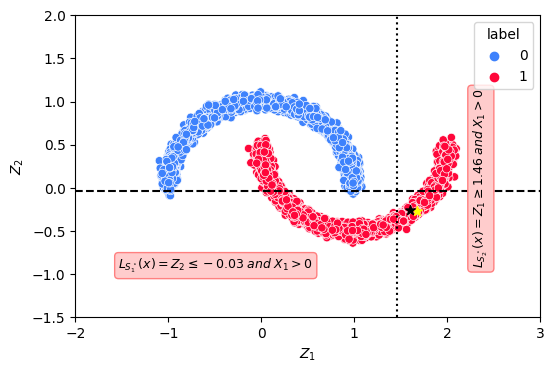

In [30]:
plt.figure(dpi=100)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
plot_X = np.c_[xx.ravel(), yy.ravel()]

def rule(X):
    Y = []
    A = []
    j = 0
    for i in range(X.shape[0]):
        if X[i, 1] <=  -0.0323284026235342 and 1.4608486890792847  <= X[i, 0]:
            j += 1
            Y.append(0)
        elif X[i, 1] >=  -0.0323284026235342 and 1.4608486890792847  <= X[i, 0]:
            Y.append(1)
        elif X[i, 1] <=  -0.0323284026235342 and 1.4608486890792847  >= X[i, 0]:
            Y.append(1)
        else:
            Y.append(4)
    return np.array(Y), np.array(A)

Z, A = rule(plot_X)
Z = Z.reshape(xx.shape)
# A = A.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, colors='white', linestyles='dashed')
# cs = plt.contourf(xx, yy, A)
# plt.colorbar()
sns.scatterplot(x='X0', y='X1', hue='label', data=data_plots[data_plots["X2"]>=0], palette=c)
plt.scatter(x_test.values[idx][0], x_test.values[idx][1], marker='*', c ='yellow', s=50)
plt.scatter(x_test.values[idx_nb][0]-0.1, x_test.values[idx_nb][1], marker='*', c ='black', s=50)
x = np.linspace(-2, 3, 100)
y = np.ones(100)*(-0.0323284026235342)
plt.plot(x, y, linestyle='dashed', color='black')
# plt.plot(-2*np.ones(100), np.linspace(-1.5, y[0], 100), linestyle='dashed', color='black')

plt.text(x[20]+0.5, y[20]-0.9, r"$L_{S^\star_1}(x)=  Z_2 \leq -0.03 \; and \; X_1 > 0$",
         horizontalalignment='center', fontsize=9, bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   ))


x = np.ones(100)*1.4608486890792847 
y = np.linspace(-1.5, 2, 100)
plt.plot(x, y, linestyle='dotted', color='black')

plt.text(x[20]+0.8, y[20]+0.9, r"$L_{S^\star_2}(x)=  Z_1 \geq 1.46 \; and \; X_1 > 0$",
         verticalalignment='center', fontsize=9, rotation='vertical', bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   ))

plt.xlabel(r'$Z_1$')
plt.ylabel(r'$Z_2$')
plt.xlim(-2, 3)
plt.ylim(-1.5, 2)